In [1]:
# this notebook will contain figures for my GSA 2021 poster
# here's what figures we'll have:
# run to steady state. Plot this on all graphs as an "initial condition"
# ramp tilt (replicate Mcmillan et al) --> translates to ~270 m uplift at western edge of our profile
# double discharge (Pelletier)

# write gaussian tilt? reference Eaton 2008? check!!

In [2]:
# start by importing libraries
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# SET UP GRID ARRAYS
dx = 1000
x = np.arange(0, 100000, dx)
q = x
double_q = 2*x

# set up references to topography
Hstar = 0.1
H = Hstar + np.zeros(len(x))
etab = -H
eta = etab + H

# abrasion coefficients from Attal and Lave 2006 in % per km
beta_ig = np.zeros(len(x))
beta_ig[:25] = 0.000004
beta_sed = np.zeros(len(x))
beta_sed[25:] = 0.000064

# erodibility values
k_ig = np.zeros(len(x))
k_ig[:25] = 0.0001
k_sed = np.zeros(len(x))
k_sed[25:] = 0.001

In [4]:
# write a function that has two bedrock lithologies in the domain, but only one contributing sediment to bedload
def two_lith_one_sed(x,
                     dx,
                     q,
                     Hstar,
                     H,
                     etab,
                     eta,
                     beta_ig,
                     beta_sed,
                     k_ig,
                     k_sed,
                     c = 1,
                     baselevel_rate = 0.001,
                     num_steps = 850000, 
                     porosity = 0.55):
    
    H[-1] = 0.0
    bedrock_ero = np.zeros(len(x))  # bedrock erosion rate
    sedimentation_rate = np.zeros(len(x))
    total_ero = np.zeros(len(x))
    qs = np.zeros(len(x))  # first node is left edge of 0th cell
    dt = 0.5 * (0.2 * dx * dx / (c*q[-1])) # time-step size

    for i in range(num_steps):
        
        # lower baselevel
        eta[-1] -= baselevel_rate * dt 
        
        # set boundary conditions
        etab[-1] = eta[-1]
        
        # calc slope
        S = -np.diff(eta)/dx
        # S = 0.001
        
        # calculate e factor
        efac = np.exp(- H / Hstar)
        
        # calculate total bedload sed flux and set boundary condition
        qs[1:] = c * q[1:] * S * (1.0 - efac[:-1])
        qs[0] = 0
        
        # calc bedrock erosion from stream power (plucking)
        ero_plucking_ig = efac[:-1] * (k_ig[1:] * q[1:] * S)
        ero_plucking_sed = efac[:-1] * (k_sed[1:] * q[1:] * S)
        
        # calc bedrock erosion from abrasion
        ero_ab_ig = efac[:-1] * (beta_ig[:-1] * qs[:-1])
        ero_ab_sed = efac[:-1] * (beta_sed[:-1] * qs[:-1])
        
        # calc bedrock erosion rate from stream power and abrasion
        bedrock_ero[:-1] = ero_plucking_ig + ero_plucking_sed + ero_ab_ig + ero_ab_sed
        
        # calc change in bedrock elev
        etab[:-1] -= bedrock_ero[:-1] * dt
        
        # calc grain attrition
        atr = 0.000004 * qs[1:]
        
        # calc change in alluvial thickness
        sedimentation_rate[:-1] = -((1 / porosity) * ((np.diff(qs)/dx) + atr - ero_plucking_ig))
        H[:-1] += sedimentation_rate[:-1] * dt
        H[H < 0] = 0
        
        # track total erosion
        total_ero = bedrock_ero - sedimentation_rate
        
        # update elev
        eta[:-1] = etab[:-1] + H[:-1]
        
    return (eta, etab, S, efac, qs, ero_plucking_ig, ero_plucking_sed, ero_ab_ig, ero_ab_sed, bedrock_ero, 
            atr, sedimentation_rate, H, total_ero)

In [5]:
# up first, run our landscape to steady state

(eta_1, 
etab_1,
S_1,
efac_1,
qs_1,
ero_plucking_ig_1, 
ero_plucking_sed_1,
ero_ab_ig_1,
ero_ab_sed_1,
bedrock_ero_1, 
atr_1, 
sedimentation_rate_1, 
H_1, 
total_ero_1) = two_lith_one_sed(x,
                                dx,
                                q,
                                Hstar,
                                H,
                                etab,
                                eta,
                                beta_ig,
                                beta_sed,
                                k_ig,
                                k_sed)

In [6]:
# make copies
eta_1_copy = eta_1.copy()
etab_1_copy = etab_1.copy()
S_1_copy = S_1.copy()
efac_1_copy = efac_1.copy()
qs_1_copy = qs_1.copy()
ero_plucking_ig_1_copy = ero_plucking_ig_1.copy()
ero_plucking_sed_1_copy = ero_plucking_sed_1.copy()
ero_ab_ig_1_copy = ero_ab_ig_1.copy()
ero_ab_sed_1_copy = ero_ab_sed_1.copy()
bedrock_ero_1_copy = bedrock_ero_1.copy()
atr_1_copy = atr_1.copy()
sedimentation_rate_1_copy = sedimentation_rate_1.copy()
H_1_copy = H_1.copy()
total_ero_1_copy = total_ero_1.copy()

In [7]:
# the above cell has created outputs for our steady state landscape
# now, we tilt the upstream (headwaters) up with a linear function

In [8]:
upstream_tilt_factor = np.linspace(270, 1, 100)

eta_tilt = eta_1 + upstream_tilt_factor
etab_tilt = etab_1 + upstream_tilt_factor

In [9]:
# now run for one time step after tectonically tilting the land surface
(eta_2, 
etab_2,
S_2,
efac_2,
qs_2,
ero_plucking_ig_2, 
ero_plucking_sed_2,
ero_ab_ig_2,
ero_ab_sed_2,
bedrock_ero_2, 
atr_2, 
sedimentation_rate_2, 
H_2, 
total_ero_2) = two_lith_one_sed(x,
                                dx,
                                q,
                                Hstar,
                                H_1,
                                etab_tilt,
                                eta_tilt,
                                beta_ig,
                                beta_sed,
                                k_ig,
                                k_sed,
                                num_steps = 1)

# make copies
eta_2_copy = eta_2.copy()
etab_2_copy = etab_2.copy()
S_2_copy = S_2.copy()
efac_2_copy = efac_2.copy()
qs_2_copy = qs_2.copy()
ero_plucking_ig_2_copy = ero_plucking_ig_2.copy()
ero_plucking_sed_2_copy = ero_plucking_sed_2.copy()
ero_ab_ig_2_copy = ero_ab_ig_2.copy()
ero_ab_sed_2_copy = ero_ab_sed_2.copy()
bedrock_ero_2_copy = bedrock_ero_2.copy()
atr_2_copy = atr_2.copy()
sedimentation_rate_2_copy = sedimentation_rate_2.copy()
H_2_copy = H_2.copy()
total_ero_2_copy = total_ero_2.copy()

In [10]:
# now run the model for a quarter of the time to steady state after tectonically tilting the land surface
(eta_3, 
etab_3,
S_3,
efac_3,
qs_3,
ero_plucking_ig_3, 
ero_plucking_sed_3,
ero_ab_ig_3,
ero_ab_sed_3,
bedrock_ero_3, 
atr_3, 
sedimentation_rate_3, 
H_3, 
total_ero_3) = two_lith_one_sed(x,
                                dx,
                                q,
                                Hstar,
                                H_1,
                                etab_tilt,
                                eta_tilt,
                                beta_ig,
                                beta_sed,
                                k_ig,
                                k_sed,
                                num_steps = 5)

# make copies
eta_3_copy = eta_3.copy()
etab_3_copy = etab_3.copy()
S_3_copy = S_3.copy()
efac_3_copy = efac_3.copy()
qs_3_copy = qs_3.copy()
ero_plucking_ig_3_copy = ero_plucking_ig_3.copy()
ero_plucking_sed_3_copy = ero_plucking_sed_3.copy()
ero_ab_ig_3_copy = ero_ab_ig_3.copy()
ero_ab_sed_3_copy = ero_ab_sed_3.copy()
bedrock_ero_3_copy = bedrock_ero_3.copy()
atr_3_copy = atr_3.copy()
sedimentation_rate_3_copy = sedimentation_rate_3.copy()
H_3_copy = H_3.copy()
total_ero_3_copy = total_ero_3.copy()

In [11]:
# now run the model for half the time to steady state after tectonically tilting the land surface
(eta_4, 
etab_4,
S_4,
efac_4,
qs_4,
ero_plucking_ig_4, 
ero_plucking_sed_4,
ero_ab_ig_4,
ero_ab_sed_4,
bedrock_ero_4, 
atr_4, 
sedimentation_rate_4, 
H_4, 
total_ero_4) = two_lith_one_sed(x,
                                dx,
                                q,
                                Hstar,
                                H_1,
                                etab_tilt,
                                eta_tilt,
                                beta_ig,
                                beta_sed,
                                k_ig,
                                k_sed,
                                num_steps = 10)

# make copies
eta_4_copy = eta_4.copy()
etab_4_copy = etab_4.copy()
S_4_copy = S_4.copy()
efac_4_copy = efac_4.copy()
qs_4_copy = qs_4.copy()
ero_plucking_ig_4_copy = ero_plucking_ig_4.copy()
ero_plucking_sed_4_copy = ero_plucking_sed_4.copy()
ero_ab_ig_4_copy = ero_ab_ig_4.copy()
ero_ab_sed_4_copy = ero_ab_sed_4.copy()
bedrock_ero_4_copy = bedrock_ero_4.copy()
atr_4_copy = atr_4.copy()
sedimentation_rate_4_copy = sedimentation_rate_4.copy()
H_4_copy = H_4.copy()
total_ero_4_copy = total_ero_4.copy()

In [12]:
eta_1 - eta_1_copy

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [13]:
# now run the model for half the time to steady state after tectonically tilting the land surface
(eta_5, 
etab_5,
S_5,
efac_5,
qs_5,
ero_plucking_ig_5, 
ero_plucking_sed_5,
ero_ab_ig_5,
ero_ab_sed_5,
bedrock_ero_5, 
atr_5, 
sedimentation_rate_5, 
H_5, 
total_ero_5) = two_lith_one_sed(x,
                                dx,
                                q,
                                Hstar,
                                H_1,
                                etab_tilt,
                                eta_tilt,
                                beta_ig,
                                beta_sed,
                                k_ig,
                                k_sed,
                                num_steps = 25)

# make copies
eta_5_copy = eta_5.copy()
etab_5_copy = etab_5.copy()
S_5_copy = S_5.copy()
efac_5_copy = efac_5.copy()
qs_5_copy = qs_5.copy()
ero_plucking_ig_5_copy = ero_plucking_ig_5.copy()
ero_plucking_sed_5_copy = ero_plucking_sed_5.copy()
ero_ab_ig_5_copy = ero_ab_ig_5.copy()
ero_ab_sed_5_copy = ero_ab_sed_5.copy()
bedrock_ero_5_copy = bedrock_ero_5.copy()
atr_5_copy = atr_5.copy()
sedimentation_rate_5_copy = sedimentation_rate_5.copy()
H_5_copy = H_5.copy()
total_ero_5_copy = total_ero_5.copy()

In [14]:
# now try writing a gaussian tilt function
# first import necessary libraries
import scipy.stats as stats
import math

# then draw the rest of the fucking bird
mu = x[0]
variance = 0.2
sigma = math.sqrt(variance)
y = np.linspace(mu + 2*sigma, mu + 0*sigma, 100)
curve = 200*stats.norm.pdf(y, mu, sigma)
reversed_curve = curve[::-1]

# great, now just add this to the landscape. Adds ~180 m at western edge
eta_gaussian = eta_1 + reversed_curve
etab_gaussian = etab_1 + reversed_curve

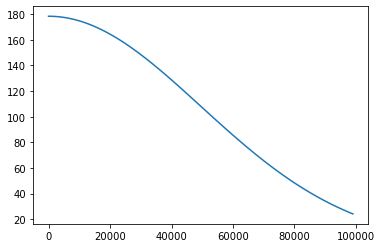

In [15]:
plt.plot(x, reversed_curve)

In [16]:
# neat, now run our guassian-tilted landscape for one timestep
(eta_6, 
etab_6,
S_6,
efac_6,
qs_6,
ero_plucking_ig_6, 
ero_plucking_sed_6,
ero_ab_ig_6,
ero_ab_sed_6,
bedrock_ero_6, 
atr_6, 
sedimentation_rate_6, 
H_6, 
total_ero_6) = two_lith_one_sed(x,
                                dx,
                                q,
                                Hstar,
                                H_1,
                                etab_gaussian,
                                eta_gaussian,
                                beta_ig,
                                beta_sed,
                                k_ig,
                                k_sed,
                                num_steps = 1)

# make copies
eta_6_copy = eta_6.copy()
etab_6_copy = etab_6.copy()
S_6_copy = S_6.copy()
efac_6_copy = efac_6.copy()
qs_6_copy = qs_6.copy()
ero_plucking_ig_6_copy = ero_plucking_ig_6.copy()
ero_plucking_sed_6_copy = ero_plucking_sed_6.copy()
ero_ab_ig_6_copy = ero_ab_ig_6.copy()
ero_ab_sed_6_copy = ero_ab_sed_6.copy()
bedrock_ero_6_copy = bedrock_ero_6.copy()
atr_6_copy = atr_6.copy()
sedimentation_rate_6_copy = sedimentation_rate_6.copy()
H_6_copy = H_6.copy()
total_ero_6_copy = total_ero_6.copy()

In [17]:
# neat, now run our guassian-tilted landscape for a quarter of the time to steady state
(eta_7, 
etab_7,
S_7,
efac_7,
qs_7,
ero_plucking_ig_7, 
ero_plucking_sed_7,
ero_ab_ig_7,
ero_ab_sed_7,
bedrock_ero_7, 
atr_7, 
sedimentation_rate_7, 
H_7, 
total_ero_7) = two_lith_one_sed(x,
                                dx,
                                q,
                                Hstar,
                                H_1,
                                etab_gaussian,
                                eta_gaussian,
                                beta_ig,
                                beta_sed,
                                k_ig,
                                k_sed,
                                num_steps = 5)

# make copies
eta_7_copy = eta_7.copy()
etab_7_copy = etab_7.copy()
S_7_copy = S_7.copy()
efac_7_copy = efac_7.copy()
qs_7_copy = qs_7.copy()
ero_plucking_ig_7_copy = ero_plucking_ig_7.copy()
ero_plucking_sed_7_copy = ero_plucking_sed_7.copy()
ero_ab_ig_7_copy = ero_ab_ig_7.copy()
ero_ab_sed_7_copy = ero_ab_sed_7.copy()
bedrock_ero_7_copy = bedrock_ero_7.copy()
atr_7_copy = atr_7.copy()
sedimentation_rate_7_copy = sedimentation_rate_7.copy()
H_7_copy = H_7.copy()
total_ero_7_copy = total_ero_7.copy()

In [18]:
# neat, now run our guassian-tilted landscape for half the time to steady state
(eta_8, 
etab_8,
S_8,
efac_8,
qs_8,
ero_plucking_ig_8, 
ero_plucking_sed_8,
ero_ab_ig_8,
ero_ab_sed_8,
bedrock_ero_8, 
atr_8, 
sedimentation_rate_8, 
H_8, 
total_ero_8) = two_lith_one_sed(x,
                                dx,
                                q,
                                Hstar,
                                H_1,
                                etab_gaussian,
                                eta_gaussian,
                                beta_ig,
                                beta_sed,
                                k_ig,
                                k_sed,
                                num_steps = 10)

# make copies
eta_8_copy = eta_8.copy()
etab_8_copy = etab_8.copy()
S_8_copy = S_8.copy()
efac_8_copy = efac_8.copy()
qs_8_copy = qs_8.copy()
ero_plucking_ig_8_copy = ero_plucking_ig_8.copy()
ero_plucking_sed_8_copy = ero_plucking_sed_8.copy()
ero_ab_ig_8_copy = ero_ab_ig_8.copy()
ero_ab_sed_8_copy = ero_ab_sed_8.copy()
bedrock_ero_8_copy = bedrock_ero_8.copy()
atr_8_copy = atr_8.copy()
sedimentation_rate_8_copy = sedimentation_rate_8.copy()
H_8_copy = H_8.copy()
total_ero_8_copy = total_ero_8.copy()

In [19]:
# neat, now run our guassian-tilted landscape for half the time to steady state
(eta_9, 
etab_9,
S_9,
efac_9,
qs_9,
ero_plucking_ig_9, 
ero_plucking_sed_9,
ero_ab_ig_9,
ero_ab_sed_9,
bedrock_ero_9, 
atr_9, 
sedimentation_rate_9, 
H_9, 
total_ero_9) = two_lith_one_sed(x,
                                dx,
                                q,
                                Hstar,
                                H_1,
                                etab_gaussian,
                                eta_gaussian,
                                beta_ig,
                                beta_sed,
                                k_ig,
                                k_sed,
                                num_steps = 25)

# make copies
eta_9_copy = eta_9.copy()
etab_9_copy = etab_9.copy()
S_9_copy = S_9.copy()
efac_9_copy = efac_9.copy()
qs_9_copy = qs_9.copy()
ero_plucking_ig_9_copy = ero_plucking_ig_9.copy()
ero_plucking_sed_9_copy = ero_plucking_sed_9.copy()
ero_ab_ig_9_copy = ero_ab_ig_9.copy()
ero_ab_sed_9_copy = ero_ab_sed_9.copy()
bedrock_ero_9_copy = bedrock_ero_9.copy()
atr_9_copy = atr_9.copy()
sedimentation_rate_9_copy = sedimentation_rate_9.copy()
H_9_copy = H_9.copy()
total_ero_9_copy = total_ero_9.copy()

In [20]:
# neat, last but not least see what happens if we double discharge -- immediately after
(eta_10, 
etab_10,
S_10,
efac_10,
qs_10,
ero_plucking_ig_10, 
ero_plucking_sed_10,
ero_ab_ig_10,
ero_ab_sed_10,
bedrock_ero_10, 
atr_10, 
sedimentation_rate_10, 
H_10, 
total_ero_10) = two_lith_one_sed(x,
                                dx,
                                double_q,
                                Hstar,
                                H_1,
                                etab_1,
                                eta_1,
                                beta_ig,
                                beta_sed,
                                k_ig,
                                k_sed,
                                num_steps = 1)

# make copies
eta_10_copy = eta_10.copy()
etab_10_copy = etab_10.copy()
S_10_copy = S_10.copy()
efac_10_copy = efac_10.copy()
qs_10_copy = qs_10.copy()
ero_plucking_ig_10_copy = ero_plucking_ig_10.copy()
ero_plucking_sed_10_copy = ero_plucking_sed_10.copy()
ero_ab_ig_10_copy = ero_ab_ig_10.copy()
ero_ab_sed_10_copy = ero_ab_sed_10.copy()
bedrock_ero_10_copy = bedrock_ero_10.copy()
atr_10_copy = atr_10.copy()
sedimentation_rate_10_copy = sedimentation_rate_10.copy()
H_10_copy = H_10.copy()
total_ero_10_copy = total_ero_10.copy()

In [21]:
# neat, last but not least see what happens if we double discharge -- then a quarter of the way to steady state
(eta_11, 
etab_11,
S_11,
efac_11,
qs_11,
ero_plucking_ig_11, 
ero_plucking_sed_11,
ero_ab_ig_11,
ero_ab_sed_11,
bedrock_ero_11, 
atr_11, 
sedimentation_rate_11, 
H_11, 
total_ero_11) = two_lith_one_sed(x,
                                dx,
                                double_q,
                                Hstar,
                                H_1,
                                etab_1,
                                eta_1,
                                beta_ig,
                                beta_sed,
                                k_ig,
                                k_sed,
                                num_steps = 5)

# make copies
eta_11_copy = eta_11.copy()
etab_11_copy = etab_11.copy()
S_11_copy = S_11.copy()
efac_11_copy = efac_11.copy()
qs_11_copy = qs_11.copy()
ero_plucking_ig_11_copy = ero_plucking_ig_11.copy()
ero_plucking_sed_11_copy = ero_plucking_sed_11.copy()
ero_ab_ig_11_copy = ero_ab_ig_11.copy()
ero_ab_sed_11_copy = ero_ab_sed_11.copy()
bedrock_ero_11_copy = bedrock_ero_11.copy()
atr_11_copy = atr_11.copy()
sedimentation_rate_11_copy = sedimentation_rate_11.copy()
H_11_copy = H_11.copy()
total_ero_11_copy = total_ero_11.copy()

In [22]:
# neat, last but not least see what happens if we double discharge -- then halfway way to steady state
(eta_12, 
etab_12,
S_12,
efac_12,
qs_12,
ero_plucking_ig_12, 
ero_plucking_sed_12,
ero_ab_ig_12,
ero_ab_sed_12,
bedrock_ero_12, 
atr_12, 
sedimentation_rate_12, 
H_12, 
total_ero_12) = two_lith_one_sed(x,
                                dx,
                                double_q,
                                Hstar,
                                H_1,
                                etab_1,
                                eta_1,
                                beta_ig,
                                beta_sed,
                                k_ig,
                                k_sed,
                                num_steps = 10)

# make copies
eta_12_copy = eta_12.copy()
etab_12_copy = etab_12.copy()
S_12_copy = S_12.copy()
efac_12_copy = efac_12.copy()
qs_12_copy = qs_12.copy()
ero_plucking_ig_12_copy = ero_plucking_ig_12.copy()
ero_plucking_sed_12_copy = ero_plucking_sed_12.copy()
ero_ab_ig_12_copy = ero_ab_ig_12.copy()
ero_ab_sed_12_copy = ero_ab_sed_12.copy()
bedrock_ero_12_copy = bedrock_ero_12.copy()
atr_12_copy = atr_12.copy()
sedimentation_rate_12_copy = sedimentation_rate_12.copy()
H_12_copy = H_12.copy()
total_ero_12_copy = total_ero_12.copy()

In [23]:
# neat, last but not least see what happens if we double discharge -- then halfway way to steady state
(eta_13, 
etab_13,
S_13,
efac_13,
qs_13,
ero_plucking_ig_13, 
ero_plucking_sed_13,
ero_ab_ig_13,
ero_ab_sed_13,
bedrock_ero_13, 
atr_13, 
sedimentation_rate_13, 
H_13, 
total_ero_13) = two_lith_one_sed(x,
                                dx,
                                double_q,
                                Hstar,
                                H_1,
                                etab_1,
                                eta_1,
                                beta_ig,
                                beta_sed,
                                k_ig,
                                k_sed,
                                num_steps = 25)

# make copies
eta_13_copy = eta_13.copy()
etab_13_copy = etab_13.copy()
S_13_copy = S_13.copy()
efac_13_copy = efac_13.copy()
qs_13_copy = qs_13.copy()
ero_plucking_ig_13_copy = ero_plucking_ig_13.copy()
ero_plucking_sed_13_copy = ero_plucking_sed_13.copy()
ero_ab_ig_13_copy = ero_ab_ig_13.copy()
ero_ab_sed_13_copy = ero_ab_sed_13.copy()
bedrock_ero_13_copy = bedrock_ero_13.copy()
atr_13_copy = atr_13.copy()
sedimentation_rate_13_copy = sedimentation_rate_13.copy()
H_13_copy = H_13.copy()
total_ero_13_copy = total_ero_13.copy()

Text(0.5, 1.0, 'Double discharge')

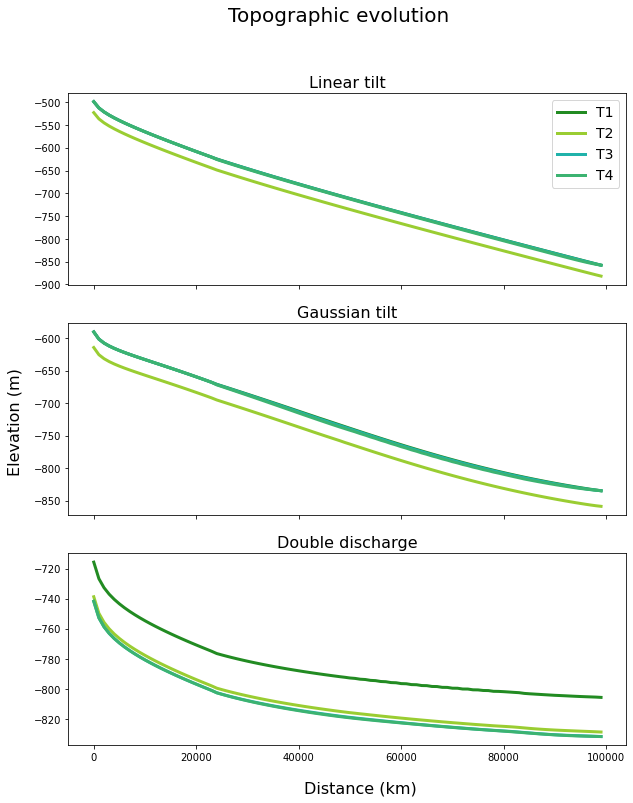

In [24]:
fig, axs = plt.subplots(3, sharex = True, figsize = (10, 12))
#plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
fig.suptitle('Topographic evolution', fontsize = 20)
fig.text(0.53, 0.07, 'Distance (km)', ha='center', fontsize = 16)
fig.text(0.04, 0.5, 'Elevation (m)', va='center', rotation='vertical', fontsize = 16)

# axs[0].plot(x, eta_1_copy, label = 'steady state', color = 'k', linewidth = 5)
axs[0].plot(x, eta_2_copy, label = 'T1', color = 'forestgreen', linewidth = 3)
axs[0].plot(x, eta_3_copy - 24, label = 'T2', color = 'yellowgreen', linewidth = 3)
axs[0].plot(x, eta_4_copy, label = 'T3', color = 'lightseagreen', linewidth = 3)
axs[0].plot(x, eta_5_copy, label = 'T4', color = 'mediumseagreen', linewidth = 3)
axs[0].legend(fontsize = 14)
axs[0].set_title('Linear tilt', fontsize = 16)

# axs[1].plot(x, eta_1_copy, color = 'k', linewidth = 5)
axs[1].plot(x, eta_6_copy, color = 'forestgreen', linewidth = 3)
axs[1].plot(x, eta_7_copy - 24, color = 'yellowgreen', linewidth = 3)
axs[1].plot(x, eta_8_copy, color = 'lightseagreen', linewidth = 3)
axs[1].plot(x, eta_9_copy, color = 'mediumseagreen', linewidth = 3)
axs[1].set_title('Gaussian tilt', fontsize = 16)

# axs[2].plot(x, eta_1_copy, color = 'k', linewidth = 5)
axs[2].plot(x, eta_10_copy + 53, color = 'forestgreen', linewidth = 3)
axs[2].plot(x, eta_11_copy + 30, color = 'yellowgreen', linewidth = 3)
axs[2].plot(x, eta_12_copy + 27, color = 'lightseagreen', linewidth = 3)
axs[2].plot(x, eta_13_copy + 27, color = 'mediumseagreen', linewidth = 3)
axs[2].set_title('Double discharge', fontsize = 16)

# plt.savefig('/Users/vanessa/Desktop/FA 2021/GSA 2021/topo evolution.png')

Text(0.5, 0, 'Distance (km)')

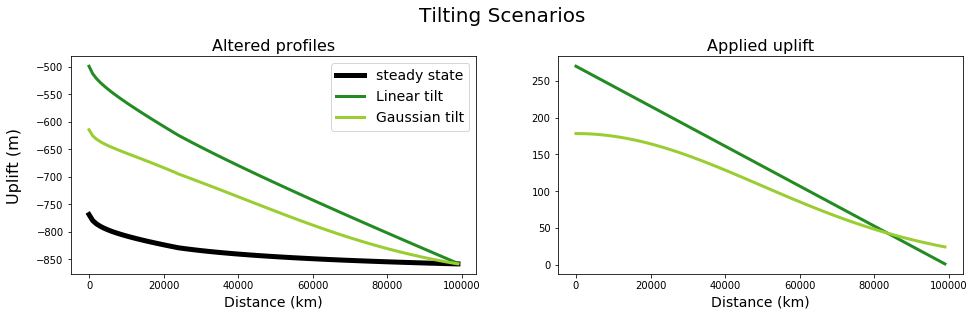

In [25]:
fig, axs = plt.subplots(1, 2, sharex = True, figsize = (16, 4))
# fig.text(0.5, -0.001, 'Distance (km)', ha='center', fontsize = 16)
fig.text(0.5, 1, 'Tilting Scenarios', ha='center', fontsize = 20)
fig.text(0.07, 0.5, 'Uplift (m)', va='center', rotation='vertical', fontsize = 16)

axs[0].plot(x, eta_1_copy, label = 'steady state', color = 'k', linewidth = 5)
axs[0].plot(x, eta_2_copy, label = 'Linear tilt', color = 'forestgreen', linewidth = 3)
axs[0].plot(x, eta_6_copy - 24, label = 'Gaussian tilt', color = 'yellowgreen', linewidth = 3)
# axs[0].plot(x, eta_10_copy, label = 'Double discharge', color = 'lightseagreen', linewidth = 3)
axs[0].legend(fontsize = 14)
axs[0].set_xlabel('Distance (km)', fontsize = 14)
axs[0].set_title('Altered profiles', fontsize = 16)

axs[1].plot(x, upstream_tilt_factor, color = 'forestgreen', linewidth = 3)
axs[1].plot(x, reversed_curve, color = 'yellowgreen', linewidth = 3)
axs[1].set_title('Applied uplift', fontsize = 16)
axs[1].set_xlabel('Distance (km)', fontsize = 14)

# plt.savefig('/Users/vanessa/Desktop/FA 2021/GSA 2021/tilting scenarios_bigfont.png', bbox_inches='tight')

Text(0.5, 1.0, 'Time 3')

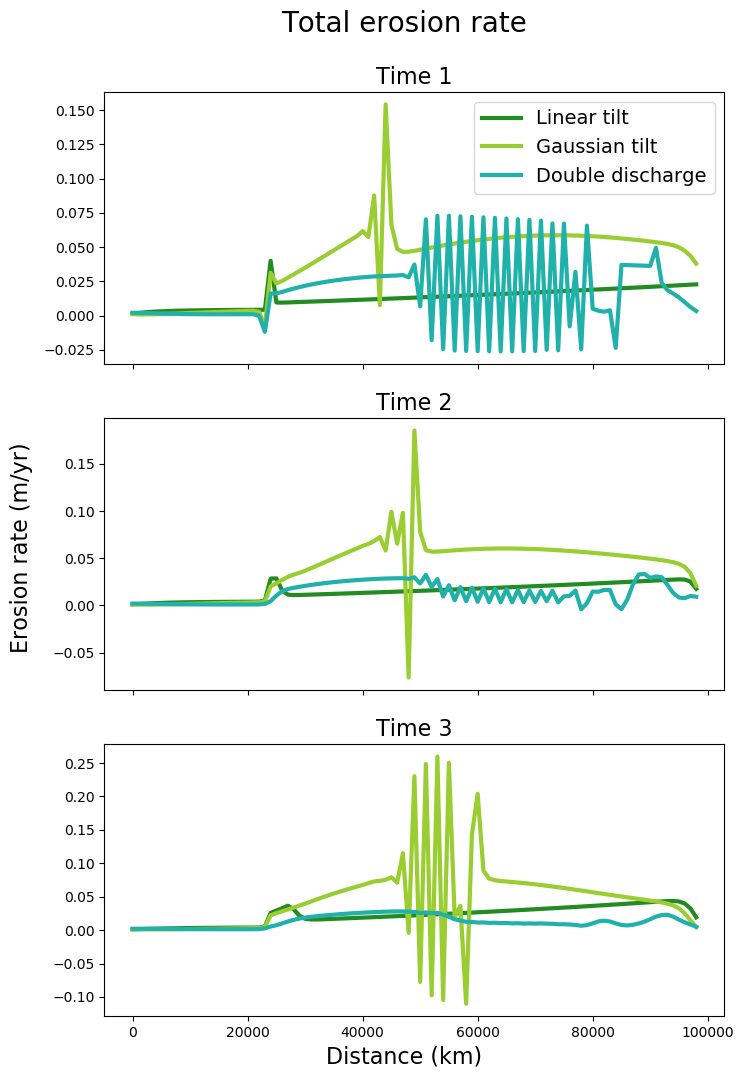

In [36]:
fig, axs = plt.subplots(3, sharex = True, figsize = (8, 12))
#plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
# fig.suptitle('Total erosion rate', fontsize = 20)
fig.text(0.5, 0.07, 'Distance (km)', ha='center', fontsize = 16)
fig.text(0.5, 0.93, 'Total erosion rate', ha='center', fontsize = 20)
fig.text(0.007, 0.5, 'Erosion rate (m/yr)', va='center', rotation='vertical', fontsize = 16)

# axs[0].plot(x, total_ero_1, label = 'steady state', color = 'k', linewidth = 5)
axs[0].plot(x[:-1], total_ero_2[:-1], label = 'Linear tilt', color = 'forestgreen', linewidth = 3)
axs[0].plot(x[:-1], total_ero_6[:-1], label = 'Gaussian tilt', color = 'yellowgreen', linewidth = 3)
axs[0].plot(x[:-1], total_ero_10[:-1], label = 'Double discharge', color = 'lightseagreen', linewidth = 3)
axs[0].legend(fontsize = 14)
axs[0].set_title('Time 1', fontsize = 16)

# axs[1].plot(x, total_ero_1, color = 'k', linewidth = 5)
axs[1].plot(x[:-1], total_ero_3[:-1], color = 'forestgreen', linewidth = 3)
axs[1].plot(x[:-1], total_ero_7[:-1], color = 'yellowgreen', linewidth = 3)
axs[1].plot(x[:-1], total_ero_11[:-1], color = 'lightseagreen', linewidth = 3)
axs[1].set_title('Time 2', fontsize = 16)

# axs[2].plot(x, total_ero_1, color = 'k', linewidth = 5)
axs[2].plot(x[:-1], total_ero_4[:-1], color = 'forestgreen', linewidth = 3)
axs[2].plot(x[:-1], total_ero_8[:-1], color = 'yellowgreen', linewidth = 3)
axs[2].plot(x[:-1], total_ero_12[:-1], color = 'lightseagreen', linewidth = 3)
axs[2].set_title('Time 3', fontsize = 16)

# plt.savefig('/Users/vanessa/Desktop/FA 2021/GSA 2021/total erosion rate.png')

Text(0.5, 1.0, 'Time 3')

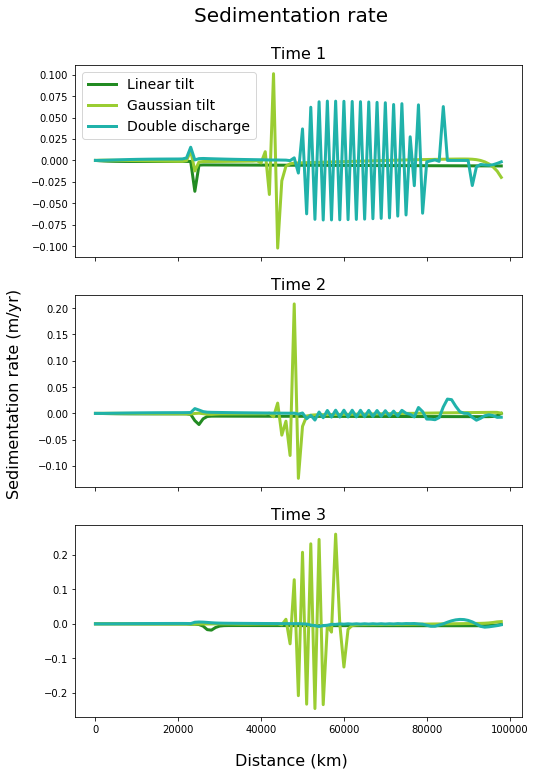

In [27]:
fig, axs = plt.subplots(3, sharex = True, figsize = (8, 12))
#plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
# fig.suptitle('Sedimentation rate', fontsize = 20)
fig.text(0.5, 0.07, 'Distance (km)', ha='center', fontsize = 16)
fig.text(0.5, 0.93, 'Sedimentation rate', ha='center', fontsize = 20)
fig.text(0.007, 0.5, 'Sedimentation rate (m/yr)', va='center', rotation='vertical', fontsize = 16)

# axs[0].plot(x, total_ero_1, label = 'steady state', color = 'k', linewidth = 5)
axs[0].plot(x[:-1], sedimentation_rate_2[:-1], label = 'Linear tilt', color = 'forestgreen', linewidth = 3)
axs[0].plot(x[:-1], sedimentation_rate_6[:-1], label = 'Gaussian tilt', color = 'yellowgreen', linewidth = 3)
axs[0].plot(x[:-1], sedimentation_rate_10[:-1], label = 'Double discharge', color = 'lightseagreen', linewidth = 3)
axs[0].legend(fontsize = 14)
axs[0].set_title('Time 1', fontsize = 16)

# axs[1].plot(x, total_ero_1, color = 'k', linewidth = 5)
axs[1].plot(x[:-1], sedimentation_rate_3[:-1], color = 'forestgreen', linewidth = 3)
axs[1].plot(x[:-1], sedimentation_rate_7[:-1], color = 'yellowgreen', linewidth = 3)
axs[1].plot(x[:-1], sedimentation_rate_11[:-1], color = 'lightseagreen', linewidth = 3)
axs[1].set_title('Time 2', fontsize = 16)

# axs[2].plot(x, total_ero_1, color = 'k', linewidth = 5)
axs[2].plot(x[:-1], sedimentation_rate_4[:-1], color = 'forestgreen', linewidth = 3)
axs[2].plot(x[:-1], sedimentation_rate_8[:-1], color = 'yellowgreen', linewidth = 3)
axs[2].plot(x[:-1], sedimentation_rate_12[:-1], color = 'lightseagreen', linewidth = 3)
axs[2].set_title('Time 3', fontsize = 16)

# plt.savefig('/Users/vanessa/Desktop/FA 2021/GSA 2021/sedimentation rate.png')

Text(0.5, 1.0, 'Time 3')

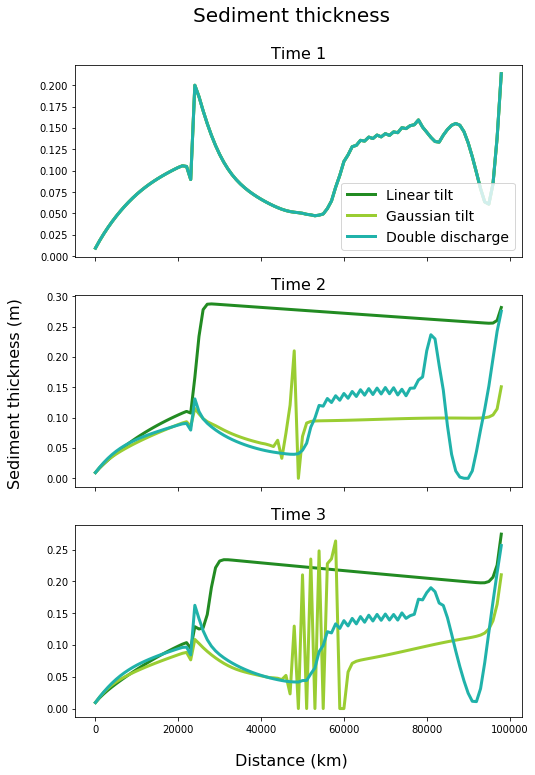

In [28]:
fig, axs = plt.subplots(3, sharex = True, figsize = (8, 12))
#plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
# fig.suptitle('Sedimentation rate', fontsize = 20)
fig.text(0.5, 0.07, 'Distance (km)', ha='center', fontsize = 16)
fig.text(0.5, 0.93, 'Sediment thickness', ha='center', fontsize = 20)
fig.text(0.007, 0.5, 'Sediment thickness (m)', va='center', rotation='vertical', fontsize = 16)

# axs[0].plot(x, total_ero_1, label = 'steady state', color = 'k', linewidth = 5)
axs[0].plot(x[:-1], H_2[:-1], label = 'Linear tilt', color = 'forestgreen', linewidth = 3)
axs[0].plot(x[:-1], H_6[:-1], label = 'Gaussian tilt', color = 'yellowgreen', linewidth = 3)
axs[0].plot(x[:-1], H_10[:-1], label = 'Double discharge', color = 'lightseagreen', linewidth = 3)
axs[0].legend(fontsize = 14)
axs[0].set_title('Time 1', fontsize = 16)

# axs[1].plot(x, total_ero_1, color = 'k', linewidth = 5)
axs[1].plot(x[:-1], H_3_copy[:-1], color = 'forestgreen', linewidth = 3)
axs[1].plot(x[:-1], H_7_copy[:-1], color = 'yellowgreen', linewidth = 3)
axs[1].plot(x[:-1], H_11_copy[:-1], color = 'lightseagreen', linewidth = 3)
axs[1].set_title('Time 2', fontsize = 16)

# axs[2].plot(x, total_ero_1, color = 'k', linewidth = 5)
axs[2].plot(x[:-1], H_4_copy[:-1], color = 'forestgreen', linewidth = 3)
axs[2].plot(x[:-1], H_8_copy[:-1], color = 'yellowgreen', linewidth = 3)
axs[2].plot(x[:-1], H_12_copy[:-1], color = 'lightseagreen', linewidth = 3)
axs[2].set_title('Time 3', fontsize = 16)

# plt.savefig('/Users/vanessa/Desktop/FA 2021/GSA 2021/sediment thickness.png')

Text(0.5, 1.0, 'Time 3')

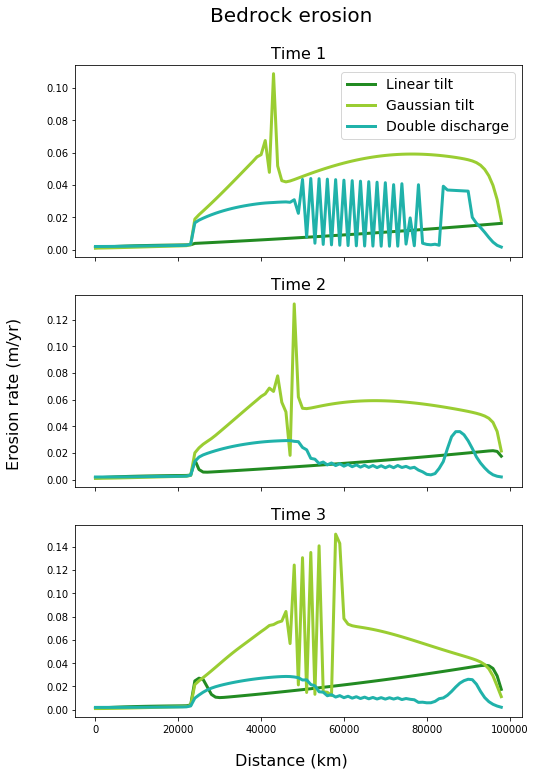

In [29]:
fig, axs = plt.subplots(3, sharex = True, figsize = (8, 12))
#plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
# fig.suptitle('Sedimentation rate', fontsize = 20)
fig.text(0.5, 0.07, 'Distance (km)', ha='center', fontsize = 16)
fig.text(0.5, 0.93, 'Bedrock erosion', ha='center', fontsize = 20)
fig.text(0.007, 0.5, 'Erosion rate (m/yr)', va='center', rotation='vertical', fontsize = 16)

# axs[0].plot(x, total_ero_1, label = 'steady state', color = 'k', linewidth = 5)
axs[0].plot(x[:-1], bedrock_ero_2[:-1], label = 'Linear tilt', color = 'forestgreen', linewidth = 3)
axs[0].plot(x[:-1], bedrock_ero_6[:-1], label = 'Gaussian tilt', color = 'yellowgreen', linewidth = 3)
axs[0].plot(x[:-1], bedrock_ero_10[:-1], label = 'Double discharge', color = 'lightseagreen', linewidth = 3)
axs[0].legend(fontsize = 14)
axs[0].set_title('Time 1', fontsize = 16)

# axs[1].plot(x, total_ero_1, color = 'k', linewidth = 5)
axs[1].plot(x[:-1], bedrock_ero_3[:-1], color = 'forestgreen', linewidth = 3)
axs[1].plot(x[:-1], bedrock_ero_7[:-1], color = 'yellowgreen', linewidth = 3)
axs[1].plot(x[:-1], bedrock_ero_11[:-1], color = 'lightseagreen', linewidth = 3)
axs[1].set_title('Time 2', fontsize = 16)

# axs[2].plot(x, total_ero_1, color = 'k', linewidth = 5)
axs[2].plot(x[:-1], bedrock_ero_4[:-1], color = 'forestgreen', linewidth = 3)
axs[2].plot(x[:-1], bedrock_ero_8[:-1], color = 'yellowgreen', linewidth = 3)
axs[2].plot(x[:-1], bedrock_ero_12[:-1], color = 'lightseagreen', linewidth = 3)
axs[2].set_title('Time 3', fontsize = 16)

# plt.savefig('/Users/vanessa/Desktop/FA 2021/GSA 2021/bedrock erosion.png')

Text(0.5, 1.0, 'Time 3')

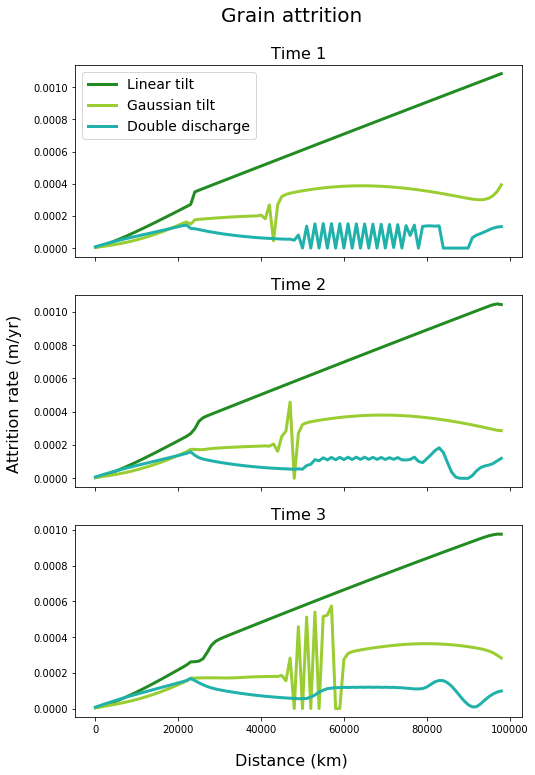

In [30]:
fig, axs = plt.subplots(3, sharex = True, figsize = (8, 12))
#plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
# fig.suptitle('Sedimentation rate', fontsize = 20)
fig.text(0.5, 0.07, 'Distance (km)', ha='center', fontsize = 16)
fig.text(0.5, 0.93, 'Grain attrition', ha='center', fontsize = 20)
fig.text(0.007, 0.5, 'Attrition rate (m/yr)', va='center', rotation='vertical', fontsize = 16)

# axs[0].plot(x, total_ero_1, label = 'steady state', color = 'k', linewidth = 5)
axs[0].plot(x[:-1], atr_2, label = 'Linear tilt', color = 'forestgreen', linewidth = 3)
axs[0].plot(x[:-1], atr_6, label = 'Gaussian tilt', color = 'yellowgreen', linewidth = 3)
axs[0].plot(x[:-1], atr_10, label = 'Double discharge', color = 'lightseagreen', linewidth = 3)
axs[0].legend(fontsize = 14)
axs[0].set_title('Time 1', fontsize = 16)

# axs[1].plot(x, total_ero_1, color = 'k', linewidth = 5)
axs[1].plot(x[:-1], atr_3, color = 'forestgreen', linewidth = 3)
axs[1].plot(x[:-1], atr_7, color = 'yellowgreen', linewidth = 3)
axs[1].plot(x[:-1], atr_11, color = 'lightseagreen', linewidth = 3)
axs[1].set_title('Time 2', fontsize = 16)

# axs[2].plot(x, total_ero_1, color = 'k', linewidth = 5)
axs[2].plot(x[:-1], atr_4, color = 'forestgreen', linewidth = 3)
axs[2].plot(x[:-1], atr_8, color = 'yellowgreen', linewidth = 3)
axs[2].plot(x[:-1], atr_12, color = 'lightseagreen', linewidth = 3)
axs[2].set_title('Time 3', fontsize = 16)

# plt.savefig('/Users/vanessa/Desktop/FA 2021/GSA 2021/attrition.png')

In [1]:
# now we switch gears and make a 3D visualization of the front range landscape

In [2]:
from landlab import RasterModelGrid
from landlab import imshow_grid
from landlab.io import read_esri_ascii
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cbook
from matplotlib import cm
from matplotlib.colors import LightSource

In [3]:
import matplotlib.pyplot as plt
import numpy as np

In [4]:
# 'modern_topo.txt' comes from Desktop/Research Fall 2020, so would need to correct path for this to work here
# but regardless, this is the code to made the 3D figure shown in "future work"
# (comes from stretched gradients.ipynb)
# just uncomment all

# now read in modern topography
(modern_grid, modern_elev) = read_esri_ascii('/Users/vanessa/Desktop/Research Fall 2020/modern_topo.txt', name = 'topographic__elevation')

# assign modern topo to new grid
new_grid = RasterModelGrid((134, 207), 5550)
new_elev = new_grid.add_zeros('node', 'topographic__elevation', units = 'm')
new_elev += modern_elev

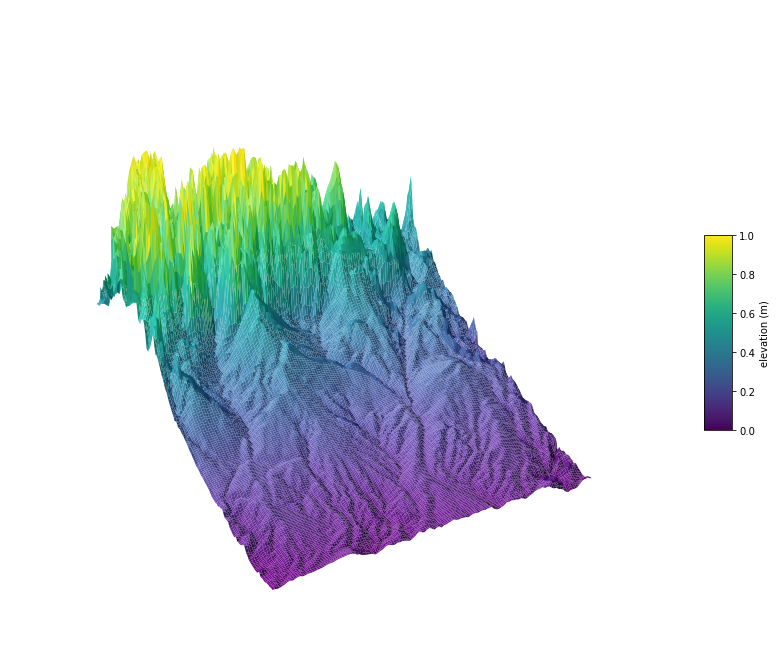

In [5]:
# now make some 3D plots

# Shape of core nodes:
# to be modified for more complex grids (use a mask?)
number_of_core_node_rows_new = new_grid.number_of_node_rows - 2
number_of_core_node_columns_new = new_grid.number_of_node_columns - 2

# number_of_core_node_rows_plains = plains_grid.number_of_node_rows - 2
# number_of_core_node_columns_plains = plains_grid.number_of_node_columns - 2

#####################################################################

### Data for 3D plot of topographic surface
X = new_grid.node_x[new_grid.core_nodes].reshape((
        number_of_core_node_rows_new, number_of_core_node_columns_new))
Y = new_grid.node_y[new_grid.core_nodes].reshape((
        number_of_core_node_rows_new, number_of_core_node_columns_new))

# X2 = plains_grid.node_x[plains_grid.core_nodes].reshape((
#         number_of_core_node_rows_plains, number_of_core_node_columns_plains))
# Y2 = plains_grid.node_y[plains_grid.core_nodes].reshape((
#         number_of_core_node_rows_plains, number_of_core_node_columns_plains))

# Elevation of core nodes, reshaped for 3D plot:
Z = new_grid.at_node['topographic__elevation'][new_grid.core_nodes].reshape(
        (number_of_core_node_rows_new, number_of_core_node_columns_new))

# Z2 = plains_grid.at_node['topographic__elevation'][plains_grid.core_nodes].reshape(
#         (number_of_core_node_rows_plains, number_of_core_node_columns_plains))

#####################################################################

### 3D plot of elevation surface:
# Figure and type of projection:
fig = plt.figure(figsize = (16, 12))
plt.style.use('default')
ax = plt.axes(projection='3d')

# Make panes transparent
ax.xaxis.pane.fill = False # Left pane
ax.yaxis.pane.fill = False # Right pane

# Remove grid lines
ax.grid(False)

# Remove tick labels
ax.set_xticklabels([])
ax.set_yticklabels([])
# ax.set_zticklabels([])

# Transparent spines
ax.w_xaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax.w_yaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax.w_zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))

# Transparent panes
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

# No ticks
ax.set_xticks([]) 
ax.set_yticks([]) 
ax.set_zticks([])

# Plot surface:
ls = LightSource(350, 45)
# To use a custom hillshading mode, override the built-in shading and pass
# in the rgb colors of the shaded surface calculated from "shade".
rgb = ls.shade(Z, cmap=cm.viridis, vert_exag=0.1, blend_mode='soft')

# ax.plot_surface(X2, Y2, Z2, cmap='coolwarm', rstride=1, cstride=1, alpha=1.0)
# surf = ax.plot_surface(X, Y, Z, cmap='viridis', rstride=1, cstride=1, alpha=1.0)
surf2 = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, facecolors=rgb,
                       linewidth=0, antialiased=True, shade=False)


fig.colorbar(surf2, shrink=0.3, aspect=7, label = 'elevation (m)')

# Set initial view of the graph (elevation and azimuth):
ax.view_init(elev = None, azim=330)

# ax.set_xlabel('1000 km')
# ax.set_ylabel('700 km')
# ax.set_zlabel('elevation')
# ax.set_xticks([0, 400, 800])

# plt.show()

# plt.savefig('/Users/vanessa/Desktop/FA 2021/GSA 2021/DEM_hillshade.png')

In [6]:
# now just try to do the same thing for the reconstruction, from ra fall 2020 folder

In [7]:
# 'modern_topo.txt' comes from Desktop/Research Fall 2020, so would need to correct path for this to work here
# but regardless, this is the code to made the 3D figure shown in "future work"
# (comes from stretched gradients.ipynb)
# just uncomment all

# now read in modern topography
(paleo_grid, paleo_elev) = read_esri_ascii('/Users/vanessa/Desktop/Research Fall 2020/reconstructed_spline.txt', name = 'topographic__elevation')

# assign modern topo to new grid
old_grid = RasterModelGrid((134, 207), 5550)
old_elev = old_grid.add_zeros('node', 'topographic__elevation', units = 'm')
old_elev += paleo_elev

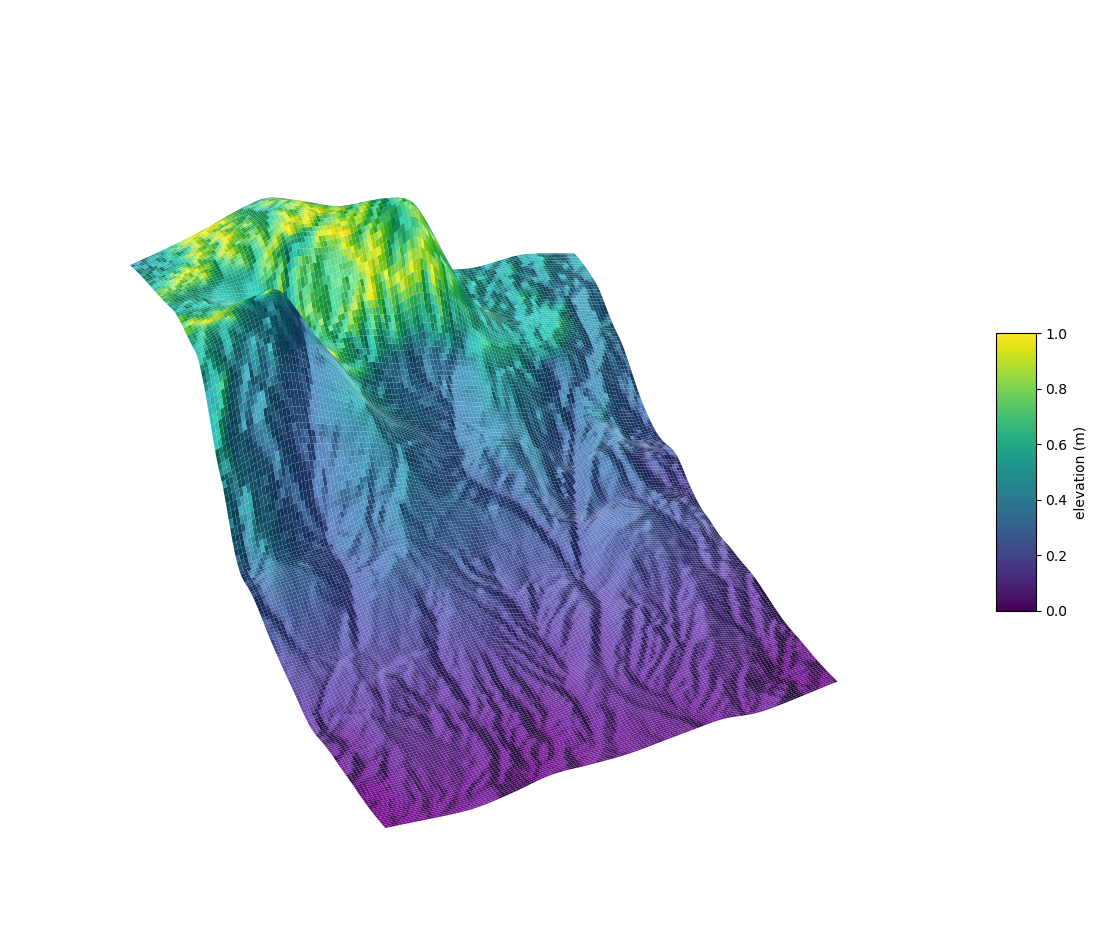

In [8]:
# now make some 3D plots

# Shape of core nodes:
# to be modified for more complex grids (use a mask?)
number_of_core_node_rows_old = old_grid.number_of_node_rows - 2
number_of_core_node_columns_old = old_grid.number_of_node_columns - 2

# number_of_core_node_rows_plains = plains_grid.number_of_node_rows - 2
# number_of_core_node_columns_plains = plains_grid.number_of_node_columns - 2

#####################################################################

### Data for 3D plot of topographic surface
X_old = old_grid.node_x[old_grid.core_nodes].reshape((
        number_of_core_node_rows_old, number_of_core_node_columns_old))
Y_old = old_grid.node_y[old_grid.core_nodes].reshape((
        number_of_core_node_rows_old, number_of_core_node_columns_old))

# X2 = plains_grid.node_x[plains_grid.core_nodes].reshape((
#         number_of_core_node_rows_plains, number_of_core_node_columns_plains))
# Y2 = plains_grid.node_y[plains_grid.core_nodes].reshape((
#         number_of_core_node_rows_plains, number_of_core_node_columns_plains))

# Elevation of core nodes, reshaped for 3D plot:
Z_old = old_grid.at_node['topographic__elevation'][old_grid.core_nodes].reshape(
        (number_of_core_node_rows_old, number_of_core_node_columns_old))

# Z2 = plains_grid.at_node['topographic__elevation'][plains_grid.core_nodes].reshape(
#         (number_of_core_node_rows_plains, number_of_core_node_columns_plains))

#####################################################################

### 3D plot of elevation surface:
# Figure and type of projection:
fig = plt.figure(figsize = (16, 12))
plt.style.use('default')
ax = plt.axes(projection='3d')

# Make panes transparent
ax.xaxis.pane.fill = False # Left pane
ax.yaxis.pane.fill = False # Right pane

# Remove grid lines
ax.grid(False)

# Remove tick labels
ax.set_xticklabels([])
ax.set_yticklabels([])
# ax.set_zticklabels([])

# Transparent spines
ax.w_xaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax.w_yaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax.w_zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))

# Transparent panes
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

# No ticks
ax.set_xticks([]) 
ax.set_yticks([]) 
ax.set_zticks([])

# Plot surface:
ls = LightSource(350, 45)
# To use a custom hillshading mode, override the built-in shading and pass
# in the rgb colors of the shaded surface calculated from "shade".
rgb = ls.shade(Z, cmap=cm.viridis, vert_exag=0.1, blend_mode='soft')

# ax.plot_surface(X2, Y2, Z2, cmap='coolwarm', rstride=1, cstride=1, alpha=1.0)
# surf = ax.plot_surface(X, Y, Z, cmap='viridis', rstride=1, cstride=1, alpha=1.0)
surf2 = ax.plot_surface(X_old, Y_old, Z_old, rstride=1, cstride=1, facecolors=rgb,
                       linewidth=0, antialiased=True, shade=False)


fig.colorbar(surf2, shrink=0.3, aspect=7, label = 'elevation (m)')

# Set initial view of the graph (elevation and azimuth):
ax.view_init(elev = None, azim=330)

# ax.set_xlabel('1000 km')
# ax.set_ylabel('700 km')
# ax.set_zlabel('elevation')
# ax.set_xticks([0, 400, 800])

# plt.show()

# plt.savefig('/Users/vanessa/Desktop/FA 2021/GSA 2021/DEM_hillshade.png')